<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

Загрузка необходимых библиотек:

In [1]:
!pip install -q nltk
!pip install -q torch
!pip install -q transformers
!pip install -q tensorflow
!pip install -q -U sentence-transformers
!pip install -q spacy
!pip install -q imblearn

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from time import time
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from nltk.corpus import stopwords
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.metrics import accuracy_score
import torch
import transformers
from tqdm import notebook
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
import spacy
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.metrics import  confusion_matrix, precision_score, recall_score
from scipy import sparse as sp
from scipy.sparse import csr_matrix, coo_matrix, hstack
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from wordcloud import WordCloud
from sklearn.linear_model import SGDClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer, pipeline
from imblearn.under_sampling import RandomUnderSampler
from transformers import BertForSequenceClassification, BertTokenizer, TextClassificationPipeline
from sklearn.model_selection import KFold

In [3]:
spacy.cli.download("en_core_web_sm");
nltk.download('punkt');

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ans\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
# криминала не было и я убрал warnings
#import warnings
#warnings.filterwarnings('ignore')

In [5]:
# Константы
RANDOM_STATE = 42
F1METRIC = 0.75
TEST_SIZE = 0.25

## Подготовка

### Загрузка и анализ данных

Чтение исходных данных в таблицы(есть основание считать, что первая колонка может иметь тип времени, попробуем это учесть при чтении таблицы):

In [6]:
try:
    toxic_tweets = pd.read_csv('toxic_comments.csv')
except:
    toxic_tweets = pd.read_csv('/datasets/toxic_comments.csv')

In [7]:
stratified_sampling = toxic_tweets.groupby('toxic').apply(lambda x: x.sample(random_state=RANDOM_STATE, frac=0.25))
toxic_tweets = stratified_sampling.droplevel(0).reset_index()

In [8]:
toxic_tweets.head(5)

,index,Unnamed: 0,text,toxic
0,145800,145956,"Press \n June 2011: Today Show, NBC: Today's M...",0
1,41036,41086,Contested deletion \n\nThis article should not...,0
2,127525,127657,"""\n Your latest edits have goen even further ...",0
3,5828,5828,"""\nIt should not be deleted, but fixed. North ...",0
4,87746,87827,I'm back... \n\n...I haven't found the rusty k...,0


Важно отметить, что комментарии на английском языке это потребуется при использовании предобученной модели BERT

Похоже, что первый столбец просто номер комментария и дублирует индекс, удалим его:

In [9]:
toxic_tweets = toxic_tweets.drop(columns = ['Unnamed: 0'])

Начальный размер таблицы:

In [10]:
full_size = toxic_tweets.shape[0]
print('Количество оригинальных записей в таблице', full_size)

Количество оригинальных записей в таблице 39822


Проверим на пропуски:

In [11]:
toxic_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39822 entries, 0 to 39821
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   39822 non-null  int64 
 1   text    39822 non-null  object
 2   toxic   39822 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 933.5+ KB


Проверим данные на наличие явных дубликатов:

In [12]:
print('Количество дубликатов:',toxic_tweets.duplicated().sum())
print(f"Процент дубликатов от объема данных: {round(toxic_tweets.duplicated().sum()/full_size*100,2)}%")

Количество дубликатов: 0
Процент дубликатов от объема данных: 0.0%


Необходимо рассмотреть варианты целевой метрики F1 или ROC-AUC (хотя она в задании указана явно, но почему бы и нет):
 - F1 Score помогает оценить способность модели правильно классифицировать положительные и отрицательные примеры. и является хорошим выбором, когда есть дисбаланс классов;
 - ROC-AUC оценивает способность модели различать между классами. Он измеряет площадь под ROC-кривой, то есть ей важен интегральный результат.

Проверим на баланс классов:

In [13]:
toxic_tweets['toxic'].value_counts(normalize=True)

0    0.898398
1    0.101602
Name: toxic, dtype: float64

Присутствут значительный дисбаланс (только около 10 % токсичные), ориентируемся на предложенную по заданию метрику, но далее покажем на наших данных их отличие

## Обучение модели классификации на основе TF-IDF и CountVectorizer

### Подготовка и предобработка текстовых данных

Удалим стоп-слова и очистим текст от паразитных знаков и символов (чтобы лемминизатору было чуть-чуть легче)

In [14]:
stopwords = set(nltk_stopwords.words('english'))

In [15]:
def clearing_text(row):
    re_pat1 = re.compile(r"([^A-Za-z']+)")
    text = re_pat1.sub(r' ' , row['text']).lower()
    text = [word for word in text.split() if word not in stopwords]
    text = " ".join(text)
    return text
#   return "".join(m.lemmatize(text))

In [16]:
%%time
toxic_tweets['cleared'] = toxic_tweets.apply(clearing_text, axis=1)

CPU times: total: 2.58 s
Wall time: 2.56 s


In [17]:
toxic_tweets.head(5)

,index,text,toxic,cleared
0,145800,"Press \n June 2011: Today Show, NBC: Today's M...",0,press june today show nbc today's money money ...
1,41036,Contested deletion \n\nThis article should not...,0,contested deletion article speedy deleted lack...
2,127525,"""\n Your latest edits have goen even further ...",0,latest edits goen even towards christian pov a...
3,5828,"""\nIt should not be deleted, but fixed. North ...",0,deleted fixed north kosovo de facto independen...
4,87746,I'm back... \n\n...I haven't found the rusty k...,0,i'm back found rusty knife yet i'm working bel...


Используем лемматизатор spaсy, отключив "parser" и  "ner"

In [18]:
disabled_list = [ "parser",  "ner", "!tok2vec", "!tagger", "!attribute_ruler"]
nlp = spacy.load('en_core_web_sm', disable=disabled_list)

In [19]:
def lemmatize_text(text, nlp):
    text = [token.lemma_ for token in nlp(text)]
    text = [word for word in text if word not in stopwords]
    return " ".join(text)

Дополнительно проверим идею, что "негативные" комментарии и сообщения скорее всего длиннее. Для этого создадим еще один столбец с количеством символов в комментарии.

In [20]:
lemmas = []
comleng= []
for i in notebook.tqdm(range(full_size)):
        comleng.append(len(toxic_tweets['cleared'][i]))
        lemmas.append(lemmatize_text(toxic_tweets['cleared'][i], nlp))
toxic_tweets['lemmas'] = lemmas
toxic_tweets['lenght'] = comleng
toxic_tweets.head(5)

  0%|          | 0/39822 [00:00<?, ?it/s]

,index,text,toxic,cleared,lemmas,lenght
0,145800,"Press \n June 2011: Today Show, NBC: Today's M...",0,press june today show nbc today's money money ...,press june today show nbc today 's money money...,395
1,41036,Contested deletion \n\nThis article should not...,0,contested deletion article speedy deleted lack...,contest deletion article speedy delete lack su...,139
2,127525,"""\n Your latest edits have goen even further ...",0,latest edits goen even towards christian pov a...,late edit goen even towards christian pov arti...,446
3,5828,"""\nIt should not be deleted, but fixed. North ...",0,deleted fixed north kosovo de facto independen...,delete fix north kosovo de facto independent a...,108
4,87746,I'm back... \n\n...I haven't found the rusty k...,0,i'm back found rusty knife yet i'm working bel...,I back find rusty knife yet I work believe mat...,89


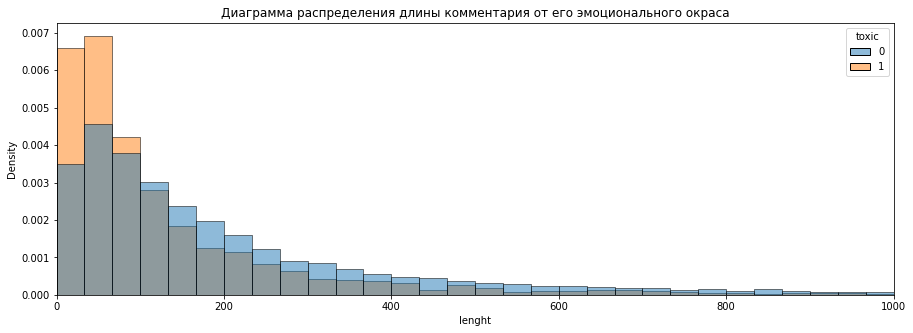

In [21]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(data=toxic_tweets, x='lenght', hue='toxic', bins=150, stat="density", common_norm=False)
plt.xlim([0, 1000])
ax.set_title("Диаграмма распределения длины комментария от его эмоционального окраса")
plt.show()

В принципе видно, что более короткие токсичнее, можно будет попробовать использовать эти данные при построении модели.

Отобразим облака слов для положительных и отрицательных комментариев

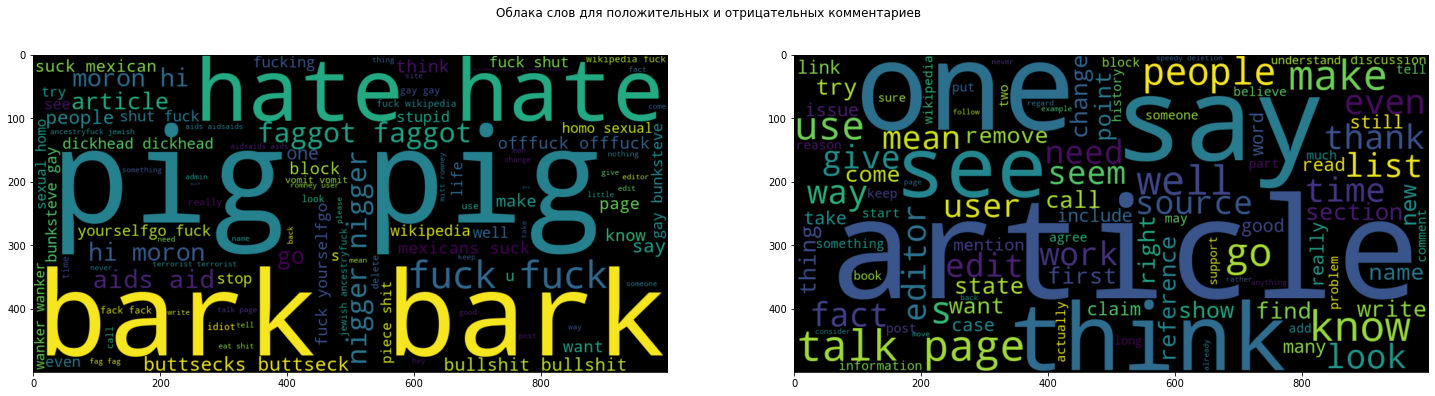

In [22]:
toxic_pos    = ' '.join(toxic_tweets[toxic_tweets['toxic'] == 1]['lemmas'])
nontoxic_pos = ' '.join(toxic_tweets[toxic_tweets['toxic'] == 0]['lemmas'])
toxic_pos_words    = WordCloud(width=1000, height=500, max_words=100, min_font_size=5).generate(toxic_pos)
nontoxic_pos_words = WordCloud(width=1000, height=500, max_words=100, min_font_size=5).generate(nontoxic_pos)
fig, ax = plt.subplots(1, 2, figsize=(25, 6))
fig.suptitle('Облака слов для положительных и отрицательных комментариев')
ax[0].imshow(toxic_pos_words, interpolation='bilinear')
ax[1].imshow(nontoxic_pos_words, interpolation='bilinear')
plt.show()

Дополнительно сравним метрики F1 и ROC-AUC на этом признаке для модели логистической регрессии:

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    toxic_tweets['lenght'], 
    toxic_tweets['toxic'], 
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE, stratify=toxic_tweets['toxic'])
X_train = X_train.values.reshape(-1, 1)
X_test = X_test.values.reshape(-1, 1) 

In [24]:
log_model = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear')

In [25]:
log_model.fit(X_train, y_train)
probability = log_model.predict_proba(X_test)[:,1]
y_predict= log_model.predict(X_train)
print('Точность модели по F1:', f1_score(y_train, y_predict)) 
print('Точность модели по ROC-AUC :', accuracy_score(y_train, y_predict)) 

Точность модели по F1: 0.0
Точность модели по ROC-AUC : 0.8984129110024778


Покажим результат предсказания на диаграмме ошибок

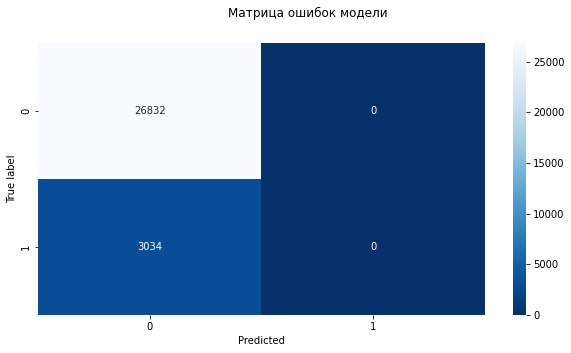

In [26]:
cm = confusion_matrix(y_train, y_predict)
plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted');
plt.suptitle('Матрица ошибок модели');
plt.show()

Модель считающая все комментарии токсичными из-за дисбаланса классов с точки зрения ROC-AUC хорошая, а вот F1 равно 0. Так как задача выявление "токсичных" комментариев выбор очевиден.

### Обучение моделей

Подбор параметров и лучшую модель будем определять на кросс-валидации для тренеровочных данных. Для сравнения создадим переменную в которую будем все записывать.

In [27]:
metrics = []

In [28]:
stopwords = set(nltk_stopwords.words('english'))

Разделим данные на тестовые и тренеровочные.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    toxic_tweets[['lemmas', 'lenght']], 
    toxic_tweets['toxic'], 
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE, stratify=toxic_tweets['toxic'])

В этом проекте раздим предобработку и модель.

Создание объекта TfidfVectorizer с использованием 50000 наиболее значимых значений, биграмм и очисткой от стоп-слов. К сформированным разряженным матрицам на основании TF-IDF подхода, добавим столбец с длиной комментария и объект CountVectorizer

In [30]:
data_preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), ['lenght']),
        ('tfidf',  TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words=stopwords), 'lemmas'),
        ('vect',   CountVectorizer(stop_words=stopwords, ngram_range=(2, 2), min_df=0.001), 'lemmas')],
         remainder='passthrough')

Я попробовал выделить главные вектора с помощью TruncatedSVD, но модель лучше не стала, а так как все значения стали не нулевые подход с разряженными матрицами тоже не прошел и время обучения выросло. В общем для текстов такое не особо работает. Если взять наиболее часто встречающиеся слова из cloud  для токсичных комментарием(и потом обработать как vocabulary), тоже не работает. Только большие данные - только TF-IDF и CountVectorizer по всем словам 🤪

In [31]:
%%time
Xscl_train = data_preprocessor.fit_transform(X_train)
Xscl_test = data_preprocessor.transform(X_test) 

CPU times: total: 8.22 s
Wall time: 8.25 s


In [32]:
def prediction_log_model(model_step, types=None):
    # выбор модели 
    if model_step == 'init':
        step_sol  = ('model', LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1', C=1))
    elif model_step == 'user':
        step_sol  = ('model', types)
    elif model_step == 'test':
        step_sol  = ('model', DummyClassifier(strategy="stratified"))
    # собираем шаги модели
    pipe_final = Pipeline([step_sol])
    return pipe_final

In [33]:
log_model = prediction_log_model('init')

In [34]:
%%time
f1_score_cv = cross_val_score(
    log_model,
    Xscl_train,
    y_train,
    scoring='f1',
    cv=5,
    n_jobs=-1
).mean()
print('Точность модели на тренировочной выборке: f1_score = ', f1_score_cv)
metrics.append(['LogReg_Init', round(f1_score_cv,2)])

Точность модели на тренировочной выборке: f1_score =  0.7394769167077472
CPU times: total: 109 ms
Wall time: 29.9 s


Получен результат сопоставимый с требованием задания

### Подбор гиперпараметров моделей

Исследуем следующие модели:
- Для **LogisticClassifier()** исследуем гиперпараметр C (l1 регуляризация) - по сильно ограничивать не будет, обучение становится очень долгим;
- Для **SGD()** исследуем гиперпараметр alpha (l1 регуляризация);
- Для **RandomForestRegressor()** max_depth ;
- Для **CatBoostRegressor()**  learning_rate;
- Для **LightGBM()**  learning_rate.

In [35]:
def param_grid_choose(type_of_model, C, learning_rate, num_leaves, max_bin, n_estimators, max_depth, min_samples_split, min_samples_leaf, alpha):
# типы моделей DecisionTreeClassifier/KNeighborsClassifier/SVC/CatBoostClassifier/LogisticRegression
    RANDOM_STATE = 42
    if type_of_model == 'LightGBM':
        # словарь для модели DecisionTreeClassifier
        param_grid = [{
        'model': [LGBMClassifier(verbose=-1)],
        'model__num_leaves': num_leaves,
        'model__max_depth': max_depth,
        'model__max_bin': max_bin
                     }]    
    elif type_of_model == 'RandomForestClassifier':
        # словарь для модели RandomForestRegressor   
        param_grid = [{
        'model': [RandomForestClassifier(n_jobs=-1, random_state=RANDOM_STATE)],
        'model__n_estimators': n_estimators, 
        'model__max_depth': max_depth,
        'model__min_samples_split': min_samples_split,
        'model__min_samples_leaf': min_samples_leaf 
            }]
    elif type_of_model == 'SGD':
        # словарь для модели метода опорных векторов
        param_grid = [{
        'model': [SGDClassifier(loss='hinge', penalty='l2',
                         alpha=1e-3, random_state=42,
                         max_iter=5, tol=None)],
        'model__alpha': alpha
                    }]
    elif type_of_model == 'CatBoostClassifier':
        # словарь для модели CatBoostClassifier   
        param_grid = [{
        'model': [CatBoostClassifier(iterations=750, loss_function='CrossEntropy', logging_level ='Silent', leaf_estimation_method='Gradient', max_ctr_complexity=1)],
        'model__learning_rate': learning_rate
                    }]
    elif type_of_model == 'LogisticClassifier':
        # словарь для модели LogisticClassifier
        param_grid = [{
        'model': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')],
        'model__C': C
                    }]
    return param_grid

In [36]:
# LogisticRegression
C              = [0.1, 0.5, 1, 2.5]        
# CatBoostClassifier & LightGBM parameters
learning_rate       = [0.1, 0.25, 0.5, 0.75]
num_leaves          = [31, 33, 35, 37]
max_bin             = [200, 255, 300]
# RandomForestClassifier parameters
n_estimators        = [10, 100] # default 100     
max_depth           = [None, 3, 5, 7] # default None 
min_samples_split   = [2, 10, 20, 30, 35] 
min_samples_leaf    = [2, 10, 20, 30, 35] 
# SGD Classifier
alpha               = [1e-1, 1e-2, 1e-3]

In [37]:
model_list = ['LightGBM' , 'LogisticClassifier', 'SGD', 'CatBoostClassifier', 'RandomForestClassifier']
#model_list = ['LightGBM']
metrics_reg = []
for i, model in enumerate(model_list):
    time2start = time()
    params   = param_grid_choose(model, C, learning_rate, num_leaves, max_bin, n_estimators, max_depth, min_samples_split, min_samples_leaf, alpha)
    searcher = RandomizedSearchCV(log_model, 
                              param_distributions = params, 
                              cv=5,
                              scoring='f1',
                              random_state=RANDOM_STATE,
                              error_score='raise',
                              n_iter=5,
                              n_jobs=-1);
    searcher.fit(Xscl_train, y_train)
    train_score = searcher.best_score_
    time2finish = time()
    dt = time2finish-time2start
    metrics_reg.append([model, train_score, str(searcher.best_estimator_.get_params()["model"]), 
                    round(dt, 2), round(searcher.cv_results_['mean_fit_time'].mean(), 2), round(searcher.cv_results_['mean_score_time'].mean(), 2), 
                    searcher.best_estimator_["model"].get_params()])
    print (model+' done')
metrics_reg = pd.DataFrame(metrics_reg)
metrics_reg.columns = ['model_list', 'f1-train', 'Лучшая модель', 'Время подбора гиперпараметров, сек', 'Время обучения модели, сек', 'Время предсказания модели, сек', 'Все параметры модели']
metrics_reg.index  = model_list
metrics_reg

LightGBM done


W:\_PracticumYandex\practicum\practicum_env\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


LogisticClassifier done


W:\_PracticumYandex\practicum\practicum_env\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=5. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


SGD done


W:\_PracticumYandex\practicum\practicum_env\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


CatBoostClassifier done
RandomForestClassifier done


,model_list,f1-train,Лучшая модель,"Время подбора гиперпараметров, сек","Время обучения модели, сек","Время предсказания модели, сек",Все параметры модели
LightGBM,LightGBM,0.656204,"LGBMClassifier(max_bin=300, max_depth=5, verbo...",107.27,29.98,0.03,"{'boosting_type': 'gbdt', 'class_weight': None..."
LogisticClassifier,LogisticClassifier,0.750200,"LogisticRegression(C=2.5, penalty='l1', random...",3.72,0.64,0.01,"{'C': 2.5, 'class_weight': None, 'dual': False..."
SGD,SGD,0.382640,"SGDClassifier(alpha=0.001, max_iter=5, random_...",0.63,0.12,0.01,"{'alpha': 0.001, 'average': False, 'class_weig..."
CatBoostClassifier,CatBoostClassifier,0.729545,<catboost.core.CatBoostClassifier object at 0x...,5943.42,2030.95,1.35,"{'iterations': 750, 'learning_rate': 0.1, 'los..."
RandomForestClassifier,RandomForestClassifier,0.568394,"RandomForestClassifier(min_samples_leaf=10, mi...",31.55,4.22,1.51,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w..."


Таким образом лучшие показатели на кросс-валидации продемонстрировали LogisticClassifier и CatBoostClassifier

## Обучение модели классификации на Bert

Обучение и обработка данных занимает значительное количество времени по-этому сократим размер выборки используя сэмпирование(возьмем 2 %). Учтем, что в выборе хотелось бы соотношение комментариев оставить прежнее.

In [74]:
stratified_sampling = toxic_tweets.groupby('toxic').apply(lambda x: x.sample(random_state=RANDOM_STATE, frac=0.05))
toxic2bert = stratified_sampling.droplevel(0)
toxic2bert['toxic'].value_counts(normalize=True)

0    0.898543
1    0.101457
Name: toxic, dtype: float64

Разобьем получившиемся данные на тренировочные и тестовые:

In [76]:
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(
    toxic2bert[['text']], 
    toxic2bert['toxic'], 
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE, stratify=toxic2bert['toxic'])

Так как в моделях Bert количество символов ограничено используем предельное значение 512

In [77]:
max_length=512

Инициализируем токенизатор и модель. 

In [78]:
path = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(path, model_max_length=max_length)
model = TFAutoModel.from_pretrained(path)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Токенизируем текст(выполним для train). Сразу сделаем padding по длине 512 и накинем маску.

In [79]:
%%time
comments = X_train_bert["text"].tolist()
tokenized = tokenizer(comments , padding='max_length', truncation=True, max_length = max_length, return_tensors="tf")

CPU times: total: 594 ms
Wall time: 897 ms


Выполним эмбеддинг

In [80]:
batch_size = 50
embeddings = []
for i in notebook.tqdm(range(len(comments) // batch_size + 1)):
        data = tokenized['input_ids'][batch_size*i:batch_size*(i+1)]
        mask = tokenized['attention_mask'][batch_size*i:batch_size*(i+1)]
#        tf.stop_gradient(
#                        batch_embeddings = model(data, mask)
#                        )
        with torch.no_grad():
                batch_embeddings = model(data, mask)
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

  0%|          | 0/30 [00:00<?, ?it/s]

In [86]:
features = np.concatenate(embeddings)

In [89]:
log_model = prediction_log_model('init')

In [90]:
model_list = ['LightGBM' , 'LogisticClassifier', 'SGD', 'CatBoostClassifier', 'RandomForestClassifier']
#model_list = ['LogisticClassifier']
metrics_reg_bert = []
for i, model in enumerate(model_list):
    time2start = time()
    params   = param_grid_choose(model, C, learning_rate, num_leaves, max_bin, n_estimators, max_depth, min_samples_split, min_samples_leaf, alpha)
    searcher = RandomizedSearchCV(log_model, 
                              param_distributions = params, 
                              cv=5,
                              scoring='f1',
                              random_state=RANDOM_STATE,
                              error_score='raise',
                              n_iter=5,
                              n_jobs=-1);
    searcher.fit(features, y_train_bert)
    train_score = searcher.best_score_
    time2finish = time()
    dt = time2finish-time2start
    metrics_reg_bert.append([model+'_bert', train_score, str(searcher.best_estimator_.get_params()["model"]), 
                    round(dt, 2), round(searcher.cv_results_['mean_fit_time'].mean(), 2), round(searcher.cv_results_['mean_score_time'].mean(), 2), 
                    searcher.best_estimator_["model"].get_params()])
    print (model+' done')
metrics_reg_bert = pd.DataFrame(metrics_reg_bert)
metrics_reg_bert.columns = ['model_list', 'f1-train', 'Лучшая модель', 'Время подбора гиперпараметров, сек', 'Время обучения модели, сек', 'Время предсказания модели, сек', 'Все параметры модели']
metrics_reg_bert.index  = model_list
metrics_reg_bert

LightGBM done


W:\_PracticumYandex\practicum\practicum_env\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


LogisticClassifier done


W:\_PracticumYandex\practicum\practicum_env\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=5. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


SGD done


W:\_PracticumYandex\practicum\practicum_env\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


CatBoostClassifier done
RandomForestClassifier done


,model_list,f1-train,Лучшая модель,"Время подбора гиперпараметров, сек","Время обучения модели, сек","Время предсказания модели, сек",Все параметры модели
LightGBM,LightGBM_bert,0.539617,"LGBMClassifier(max_bin=255, max_depth=5, num_l...",77.66,21.24,0.01,"{'boosting_type': 'gbdt', 'class_weight': None..."
LogisticClassifier,LogisticClassifier_bert,0.605623,"LogisticRegression(C=2.5, penalty='l1', random...",3.95,0.66,0.01,"{'C': 2.5, 'class_weight': None, 'dual': False..."
SGD,SGD_bert,0.532123,"SGDClassifier(alpha=0.001, max_iter=5, random_...",0.33,0.04,0.01,"{'alpha': 0.001, 'average': False, 'class_weig..."
CatBoostClassifier,CatBoostClassifier_bert,0.556617,<catboost.core.CatBoostClassifier object at 0x...,2447.50,837.61,0.09,"{'iterations': 750, 'learning_rate': 0.5, 'los..."
RandomForestClassifier,RandomForestClassifier_bert,0.353903,"RandomForestClassifier(min_samples_leaf=10, mi...",16.54,0.71,0.18,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w..."


## Реализация предобученной модели (Jungle Lee/bert-toxic-comment-classification)

Ради интереса воспользуемся подготовленной моделью для прогнозирования токсичности комментариев https://huggingface.co/JungleLee/bert-toxic-comment-classification

In [91]:
model_path = "JungleLee/bert-toxic-comment-classification"
tokenizer = BertTokenizer.from_pretrained(model_path, model_max_length=max_length,  padding='max_length', truncation=True, max_length = max_length)
model = BertForSequenceClassification.from_pretrained(model_path, num_labels=2)

Создадим pipeline

In [92]:
Classifier = TextClassificationPipeline(model=model, tokenizer=tokenizer)

In [93]:
comments = X_train_bert["text"].tolist()

Так как модель собрана и обучена изначально, не представляю как ее исследовать на кросс-валидации, по-этому просто сравним получаемые значения на тестовых кроссвалидационных выборках.

In [94]:
kf = KFold(n_splits=5, shuffle = True, random_state=RANDOM_STATE)

In [95]:
cv_scores = np.empty(5)
batch_size = 16
for i, (train_index, test_index) in enumerate(kf.split(X_train_bert)):
    test_cv = X_train_bert["text"].iloc[test_index]
    comments = test_cv.tolist()
    toxicity_scores = []
    for j in notebook.tqdm(range(test_cv.shape[0]// batch_size+1)):
        batch = comments[j:j+batch_size]
        batch_scores = Classifier(batch, truncation=True, max_length = max_length)
        score2string = [entry['label'] for entry in batch_scores]
        toxicity_scores.extend(score2string)
    toxicity_scores = [1 if x == 'toxic' else 0 for x in toxicity_scores]
    toxicity_scores = toxicity_scores[0:test_cv.shape[0]]
    # Оценка точности модели
    cv_scores[i] = f1_score(y_train.iloc[test_index], toxicity_scores)
    print('Fold '+ str(i) + ' done')
print('Точность модели непонятно на чем: f1 = ', np.mean(cv_scores))
metrics.append(['JungleLee pretrained Model', round(np.mean(cv_scores),2)])

  0%|          | 0/19 [00:00<?, ?it/s]

Fold 0 done


  0%|          | 0/19 [00:00<?, ?it/s]

Fold 1 done


  0%|          | 0/19 [00:00<?, ?it/s]

Fold 2 done


  0%|          | 0/19 [00:00<?, ?it/s]

Fold 3 done


  0%|          | 0/19 [00:00<?, ?it/s]

Fold 4 done
Точность модели непонятно на чем: f1 =  0.12660473550768342


C:\Users\ans\AppData\Local\Temp\ipykernel_17976\3395826203.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics.append(['JungleLee pretrained Model', round(np.mean(cv_scores),2)])


,model_list,f1-train,0
0,LogReg_Init,0.74,NaN
1,JungleLee pretrained Model,0.06,NaN
0,NaN,NaN,JungleLee pretrained Model
1,NaN,NaN,0.13


Вывод тут, что наверное правильнее делать embedding, потому что "токсичность" это видимо очень широкое понятие

## Анализ результатов моделирования

Сравним результаты на тренировочных выборках и выберем наилучшию модель для прогнозирования на тестовых данных

In [64]:
metrics = pd.DataFrame(metrics)
metrics.columns = ['model_list', 'f1-train']

In [97]:
metrics_rez=pd.concat([metrics, metrics_reg[['model_list', 'f1-train']]], ignore_index=True)
metrics_rez=pd.concat([metrics_rez, metrics_reg_bert[['model_list', 'f1-train']]], ignore_index=True).sort_values('f1-train', ascending=False)
metrics_rez

,model_list,f1-train
3,LogisticClassifier,0.750200
0,LogReg_Init,0.740000
5,CatBoostClassifier,0.729545
2,LightGBM,0.656204
8,LogisticClassifier_bert,0.605623
6,RandomForestClassifier,0.568394
10,CatBoostClassifier_bert,0.556617
7,LightGBM_bert,0.539617
9,SGD_bert,0.532123
4,SGD,0.382640


Таким образом, на тренировочных данных лучшие показатели получены на  TF-IDF и CountVectorizer признаках и модели LogisticClassifier.

In [66]:
model = LogisticRegression(C=2.5, penalty='l1', random_state=42, solver='liblinear')
final_model = prediction_log_model('user', types = model)

In [69]:
final_model.fit(Xscl_train, y_train)
y_pred = final_model.predict(Xscl_test)
print('Точность модели на тестовой выборке: f1 = ',f1_score(y_test.values.ravel(), y_pred))

Точность модели на тестовой выборке: f1 =  0.7567873303167422


In [ ]:
metrics_reg_bert['Лучшая модель']['LogisticClassifier']

## Выводы

* Данные импортированы, изучены. Дубликатов и пропусков не наблюдается. Дисбаланс классов - `0` - `89,84%`, `1` - `10,16%`;
* Проведено разбиение текста на токены и лемматизация;
* После получения векторного представления была проведена классификация с помощью моделей **LogisticClassifier()**,  **SGD()**, **RandomForestRegressor()**, **CatBoostRegressor()**, **LightGBM()**.  Величины метрик `f1`, полученные на тестовой выборке говорят о том, что в большей степени на качество предсказания влияет предобработка текста.
* По результатам расчетов достичь требуемо величины метрики `f1` удалось только при сочетании TF-IDF и CountVectorizer;
* Возможно, лучшие значения метрик можнобыло бы получить и с помощью BERT, увеличив размер обучающей и тестовой выборок, однако не хватило памяти на локальном компьютере.
* Лучшее значение метрики `f1` на тестовых данных составило 0.75, что соответствует заданию.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны